## Сборный проект-4  

Нам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

In [132]:
# Загрузим необходимые библиотеки


from transformers import BertTokenizer, BertModel
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from keras.layers import Embedding
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from matplotlib import pyplot as plt
from ipywidgets import IntProgress

import os
import re
import nltk
import pickle
import spacy

import warnings
import keras_nlp
import transformers
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers as ppb

import seaborn as sns
from PIL import Image
from pathlib import Path
from tqdm import notebook
from tqdm.notebook import tqdm
from os.path import exists, isfile, join
tqdm.pandas()


warnings.filterwarnings('ignore')


In [133]:
# Вынесем константы

PATH = 'C:/Users/User/Desktop/dsplus_integrated_project_4/to_upload'
PATH_train_images = 'C:/Users/User/Desktop/dsplus_integrated_project_4/to_upload/train_images'
BANNED_CONTENT = ['child', 'boy', 'girl', 'baby', 'teen', 'teenager', 'kid', 'infant',
                 'youngster', 'kids', 'children', 'boys', 'girls', 'babies', 'teens', 'teenagers', 'stripling']
SEED = 19811922


In [134]:
# Откроем данные

df_train = pd.read_csv(
    'C:/Users/User/Desktop/dsplus_integrated_project_4/to_upload/train_dataset.csv')
test_images = pd.read_csv(
    'C:/Users/User/Desktop/dsplus_integrated_project_4/to_upload/test_images.csv')
test_queries = pd.read_csv(
    'C:/Users/User/Desktop/dsplus_integrated_project_4/to_upload/test_queries.csv', index_col=[0], sep='|')
expert = pd.read_csv('C:/Users/User/Desktop/dsplus_integrated_project_4/to_upload/ExpertAnnotations.tsv',
                     sep='\t', names=['image', 'description_id', 'expert_1', 'expert_2', 'expert_3'])

crowd = pd.read_csv('C:/Users/User/Desktop/dsplus_integrated_project_4/to_upload/CrowdAnnotations.tsv',
                    sep='\t', names=['image', 'crowd_id', 'fraction_respond', 'count_respond', 'count_not_raspond'])


In [135]:
# Напишем функцию для просмотра данных

def info(df):
    display(df.info())
    display(df.sample(n=5))
    display(df.describe())


In [136]:
# Посмотрим на данные в train_dataset

info(df_train)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

image                     query_id  \
1205  1311388430_4ab0cd1a1f.jpg  2892995070_39f3c9a56e.jpg#2   
5561  3275704430_a75828048f.jpg  2041867793_552819a40b.jpg#2   
197   1084040636_97d9633581.jpg  3385593926_d3e9c21170.jpg#2   
1078  1282392036_5a0328eb86.jpg  2542662402_d781dd7f7c.jpg#2   
1016  2718024196_3ff660416a.jpg  3514019869_7de4ece2a5.jpg#2   

                                             query_text  
1205  A brown dog leaps into the air next to a black...  
5561            A young child wearing a mask at Ivars .  
197        Two brown dogs playfully fight in the snow .  
1078  A woman next to a dog which is running an obst...  
1016                     A dog jumps over an obstacle .

image                     query_id  \
count                        5822                         5822   
unique                       1000                          977   
top     3364151356_eecd07a23e.jpg  2600867924_cd502fc911.jpg#2   
freq                           10                           34   

                                               query_text  
count                                                5822  
unique                                                977  
top     Two dogs , one brown and white and one black a...  
freq                                                   34

Как видно, в датасете 5822 строки.
В таблице содержится 3 столбца:  
- image - имя файла изображения  
- query_id - идентификатор описания  
- query_text - текст описания  
Также видим, что у нас 1000 уникальных фотографий, которым соответствует 977 уникальных описаний


In [137]:
# Переименуем столбцы

df_train = df_train.rename(
    columns={'query_id': 'description_id', 'query_text': 'description_text'})


In [138]:
df_train


image               description_id  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1     1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2     2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3     2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4     2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
...                         ...                          ...   
5817   757046028_ff5999f91b.jpg  2061144717_5b3a1864f0.jpg#2   
5818   799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2   
5819   909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
5820   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5821   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                       description_text  
0     A young child is wearing blue goggles and sitt...  
1     A young child is wearing blue goggles and sitt...  
2     A young child is wearing blue goggles and sitt...  
3     A young child is wearing blue goggles and sitt...  
4     A young child is wearing blue goggles and sitt...  
...                                                 ...  
5817         A man in an ampitheater talking to a boy .  
5818          a old man walks down the uncrowded road .  
5819       A dog stands on the side of a grassy cliff .  
5820                       A blurry photo of two dogs .  
5821                        A man rows his boat below .  

[5822 rows x 3 columns]

In [139]:
# Посмотрим на данные в test_queries

info(test_queries)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


None

query_id  \
379  3514297698_0512623955.jpg#4   
480   957682378_46c3b07bcd.jpg#0   
446   572618443_647483ca82.jpg#1   
36   1745110280_0cbff5e273.jpg#1   
201  3033612929_764d977bd5.jpg#1   

                                            query_text  \
379  A spotted dog stands on his hind legs to catch...   
480  A brown dog and a black dog run into each othe...   
446  A shirtless male looks to his right while wate...   
36   A caramel colored dog sits in front of trees l...   
201  A small white dog is carrying something blue i...   

                         image  
379  3514297698_0512623955.jpg  
480   957682378_46c3b07bcd.jpg  
446   572618443_647483ca82.jpg  
36   1745110280_0cbff5e273.jpg  
201  3033612929_764d977bd5.jpg

query_id  \
count                           500   
unique                          500   
top     1177994172_10d143cb8d.jpg#0   
freq                              1   

                                               query_text  \
count                                                 500   
unique                                                500   
top     Two blonde boys , one in a camouflage shirt an...   
freq                                                    1   

                            image  
count                         500  
unique                        100  
top     1177994172_10d143cb8d.jpg  
freq                            5

В данной таблице у нас 500 строк и три столбца.  
- query_id -  идентификатор запроса  
- query_text - текст запроса  
- image - релевантное изображение 
У нас 100 уникальных изображений, которым соответствует 500 описаний.

In [140]:
info(test_images)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


None

image
19  3653484549_f316590b0f.jpg
42  3520936130_9e90872560.jpg
16   989851184_9ef368e520.jpg
17  2505465055_f1e6cf9b76.jpg
24  3421547427_53411b6278.jpg

image
count                         100
unique                        100
top     3356748019_2251399314.jpg
freq                            1

In [141]:
# Посмотрим на данные в файле ExpertAnnotations

info(expert)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image           5822 non-null   object
 1   description_id  5822 non-null   object
 2   expert_1        5822 non-null   int64 
 3   expert_2        5822 non-null   int64 
 4   expert_3        5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


None

image               description_id  expert_1  \
2823  3044500219_778f9f2b71.jpg  3143982558_9e2d44c155.jpg#2         1   
4969  3708177171_529bb4ff1d.jpg  1461667284_041c8a2475.jpg#2         1   
1477  2470486377_c3a39ccb7b.jpg  2225231022_1632d0a5aa.jpg#2         1   
3838  3350786891_6d39b234e9.jpg  1536774449_e16b1b6382.jpg#2         2   
1769  2575647360_f5de38c751.jpg  1425069308_488e5fcf9d.jpg#2         1   

      expert_2  expert_3  
2823         1         1  
4969         1         2  
1477         2         2  
3838         2         3  
1769         2         2

expert_1     expert_2     expert_3
count  5822.000000  5822.000000  5822.000000
mean      1.436620     1.624356     1.881999
std       0.787084     0.856222     0.904087
min       1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000
50%       1.000000     1.000000     2.000000
75%       2.000000     2.000000     2.000000
max       4.000000     4.000000     4.000000

In [142]:
expert['expert_1'].value_counts()


1    4120
2    1109
3     346
4     247
Name: expert_1, dtype: int64

In [143]:
display(expert['expert_1'].value_counts(normalize=True))
display(expert['expert_2'].value_counts(normalize=True))
display(expert['expert_3'].value_counts(normalize=True))


1    0.707661
2    0.190484
3    0.059430
4    0.042425
Name: expert_1, dtype: float64

1    0.571453
2    0.286156
3    0.088973
4    0.053418
Name: expert_2, dtype: float64

1    0.403641
2    0.381656
3    0.143765
4    0.070938
Name: expert_3, dtype: float64

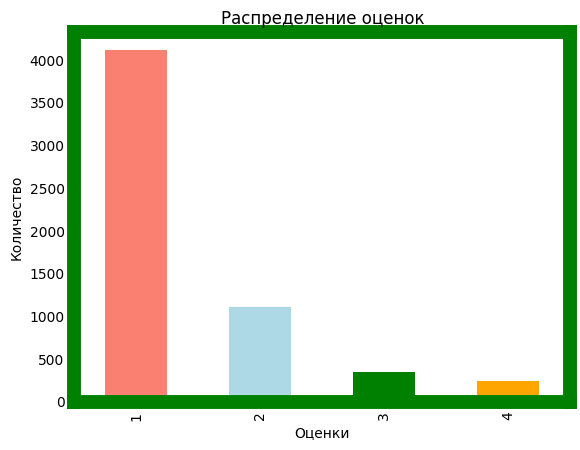

In [144]:
expert['expert_1'].value_counts().plot(
    kind='bar', color=['salmon', 'lightblue', 'green', 'orange'])
plt.title('Распределение оценок')
plt.xlabel('Оценки')
plt.ylabel('Количество')
plt.show()


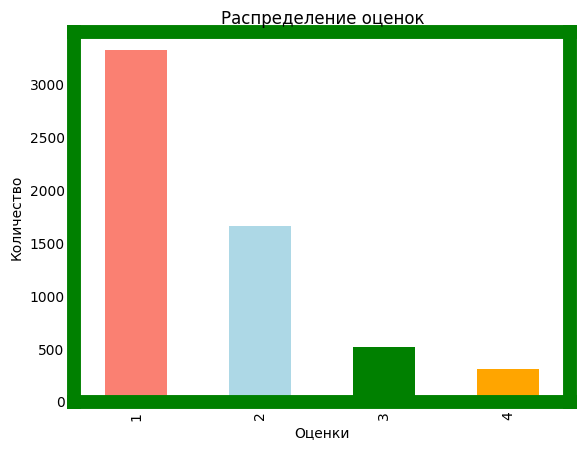

In [145]:
expert['expert_2'].value_counts().plot(
    kind='bar', color=['salmon', 'lightblue', 'green', 'orange'])
plt.title('Распределение оценок')
plt.xlabel('Оценки')
plt.ylabel('Количество')
plt.show()


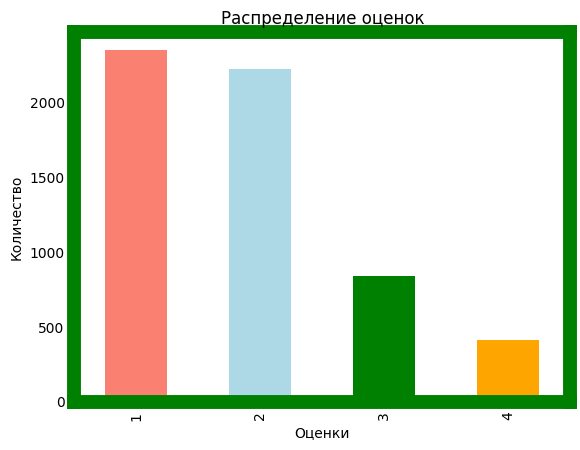

In [146]:
expert['expert_3'].value_counts().plot(
    kind='bar', color=['salmon', 'lightblue', 'green', 'orange'])
plt.title('Распределение оценок')
plt.xlabel('Оценки')
plt.ylabel('Количество')
plt.show()


Как видно, в файле 5822 строки.
В таблице содержится 5 столбцов:  
- image - имя файла изображения  
- description_id - идентификатор описания  
- expert_1, 2, 3 - оценки трех экспертов  
Описание оценок экспертов:  
- 1 - изображение и запрос совершенно не соответствуют друг другу  
- 2 - запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует  
- 3 - запрос и текст соответствуют с точностью до некоторых деталей  
- 4 - запрос и текст соответствуют полностью  
Видно что средние оценки 1 и 2 эксперта меньше 2, средняя оценка третьего эксперта близка к двум. 

In [147]:
# Посмотрим на файл CrowdAnnotations

info(crowd)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   image              47830 non-null  object 
 1   crowd_id           47830 non-null  object 
 2   fraction_respond   47830 non-null  float64
 3   count_respond      47830 non-null  int64  
 4   count_not_raspond  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

image                     crowd_id  \
21171  2938747424_64e64784f0.jpg  3651971126_309e6a5e22.jpg#2   
14221   256085101_2c2617c5d0.jpg  2929506802_5432054d77.jpg#2   
21823  2968182121_b3b491df85.jpg  3452127051_fa54a902b3.jpg#2   
24162  3080056515_3013830309.jpg  3150742439_b8a352e1e0.jpg#2   
22673  3017521547_f5ef8848e3.jpg  3135504530_0f4130d8f8.jpg#2   

       fraction_respond  count_respond  count_not_raspond  
21171               0.0              0                  3  
14221               0.0              0                  4  
21823               0.0              0                  3  
24162               0.0              0                  3  
22673               0.0              0                  3

fraction_respond  count_respond  count_not_raspond
count      47830.000000   47830.000000       47830.000000
mean           0.068786       0.208488           2.820155
std            0.207532       0.628898           0.656676
min            0.000000       0.000000           0.000000
25%            0.000000       0.000000           3.000000
50%            0.000000       0.000000           3.000000
75%            0.000000       0.000000           3.000000
max            1.000000       5.000000           6.000000

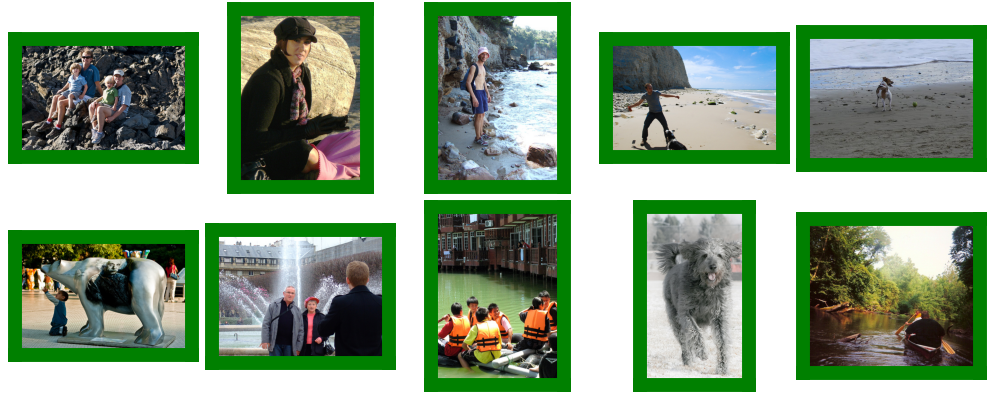

In [148]:
# Посмотрим на 10 случайных фото на трейне

train_samp = list(df_train['image'].sample(10))

fig = plt.figure(figsize=(10, 10))
for i in range(10):
    fig.add_subplot(5, 5, i+1)
    image = Image.open(Path(PATH, 'train_images', train_samp[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()


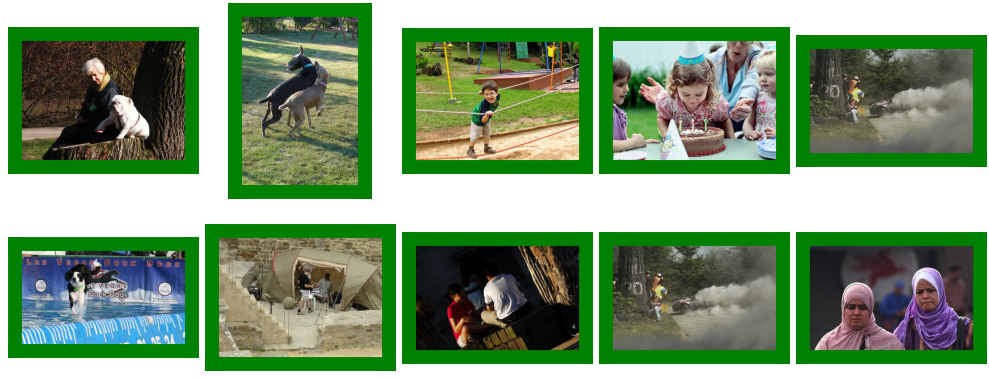

In [149]:
# Посмотрим на 10 случайных фото на тесте

test_samp = list(test_queries['image'].sample(10))

fig = plt.figure(figsize=(10, 10))
for i in range(10):
    fig.add_subplot(5, 5, i+1)
    image = Image.open(Path(PATH, 'test_images', test_samp[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()


**Вывод:**  
Мы посмотрели данные исходя из оценок экспертов можно сказать, что изображения и описания в большинстве случаев не соответствуют друг другу.

## Агрегация оценок

Произведем агрегацию оценок методом большинства. Если все оценки разные, то оценку не выставляем

In [150]:
# Напишем функцию для агрегации

def choice(exp1, exp2, exp3):
    if exp1 == exp2 or exp1 == exp3:
        return exp1
    elif exp2 == exp3:
        return exp2
    else:
        return None


In [151]:
# Добавим результат агрегации

expert['results_experts'] = expert.apply(
    lambda x: choice(x['expert_1'], x['expert_2'], x['expert_3']), axis=1)


In [152]:
expert


image               description_id  expert_1  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1   
1     1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1   
2     1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1   
3     1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1   
4     1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1   
...                         ...                          ...       ...   
5817   997722733_0cb5439472.jpg  2981702521_2459f2c1c4.jpg#2         1   
5818   997722733_0cb5439472.jpg  2985679744_75a7102aab.jpg#2         1   
5819   997722733_0cb5439472.jpg  3150742439_b8a352e1e0.jpg#2         1   
5820   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2         1   
5821   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2         3   

      expert_2  expert_3  results_experts  
0            1         1              1.0  
1            1         2              1.0  
2            1         2              1.0  
3            2         2              2.0  
4            1         2              1.0  
...        ...       ...              ...  
5817         1         1              1.0  
5818         1         1              1.0  
5819         1         2              1.0  
5820         1         1              1.0  
5821         3         3              3.0  

[5822 rows x 6 columns]

In [153]:
# Удалим строки без оценок

expert = expert.dropna(subset=['results_experts'])


In [154]:
expert['results_experts'].value_counts(normalize=True)


1.0    0.584094
2.0    0.274930
3.0    0.086376
4.0    0.054600
Name: results_experts, dtype: float64

In [155]:

m_scaler = MinMaxScaler()


In [156]:
# Приведем оценки к диапозону от 0 до 1

expert['results_experts'] = m_scaler.fit_transform(expert[['results_experts']])


In [157]:
expert.shape


(5696, 6)

In [158]:
# Добавим оценки в тренировочный датасет

df_train = (df_train.set_index(['image', 'description_id'])
            .join(expert.set_index(['image', 'description_id'])[['results_experts']],
                  how='inner',).reset_index())


Объединять датасеты оценок и экспертов я не стал. Т.к. даже среди оценок экспертов результаты не очень хорошие.

## Проверка данных

Очистим текст и выделим слова, которые попадают под ограничения

In [159]:
# Функция очищения текстов 

def clear_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text) 
    text = text.split()  
    text = ' '.join(text)
    return text

In [160]:
df_train['description_text'] = df_train['description_text'].progress_apply(clear_text) 

  0%|          | 0/5696 [00:00<?, ?it/s]

In [161]:
# Проведем лемматизацию при помощи spacy

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
def spacy_lemm(sentence):
    doc = nlp(sentence)
    return " ".join([token.lemma_ for token in doc])

df_train['description_text'] = df_train['description_text'].progress_apply(spacy_lemm)

  0%|          | 0/5696 [00:00<?, ?it/s]

In [162]:
def stop(text: str) -> bool:
    var = False
    for i in BANNED_CONTENT:
        var |= text.lower().find(i) > -1
    return var

In [163]:
df_train['block'] = df_train.apply(
    lambda x: stop(x['description_text']), axis=1)

In [164]:
df_train

image               description_id  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1     1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2     2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3     2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4     2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
...                         ...                          ...   
5691   757046028_ff5999f91b.jpg  2061144717_5b3a1864f0.jpg#2   
5692   799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2   
5693   909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
5694   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5695   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                       description_text  results_experts  \
0     a young child be wear blue goggle and sit in a...         0.000000   
1     a young child be wear blue goggle and sit in a...         0.000000   
2     a young child be wear blue goggle and sit in a...         0.333333   
3     a young child be wear blue goggle and sit in a...         1.000000   
4     a young child be wear blue goggle and sit in a...         0.000000   
...                                                 ...              ...   
5691              a man in an ampitheater talk to a boy         0.333333   
5692             a old man walk down the uncrowded road         0.000000   
5693          a dog stand on the side of a grassy cliff         0.333333   
5694                          a blurry photo of two dog         0.666667   
5695                           a man row his boat below         0.000000   

      block  
0      True  
1      True  
2      True  
3      True  
4      True  
...     ...  
5691   True  
5692  False  
5693  False  
5694  False  
5695  False  

[5696 rows x 5 columns]

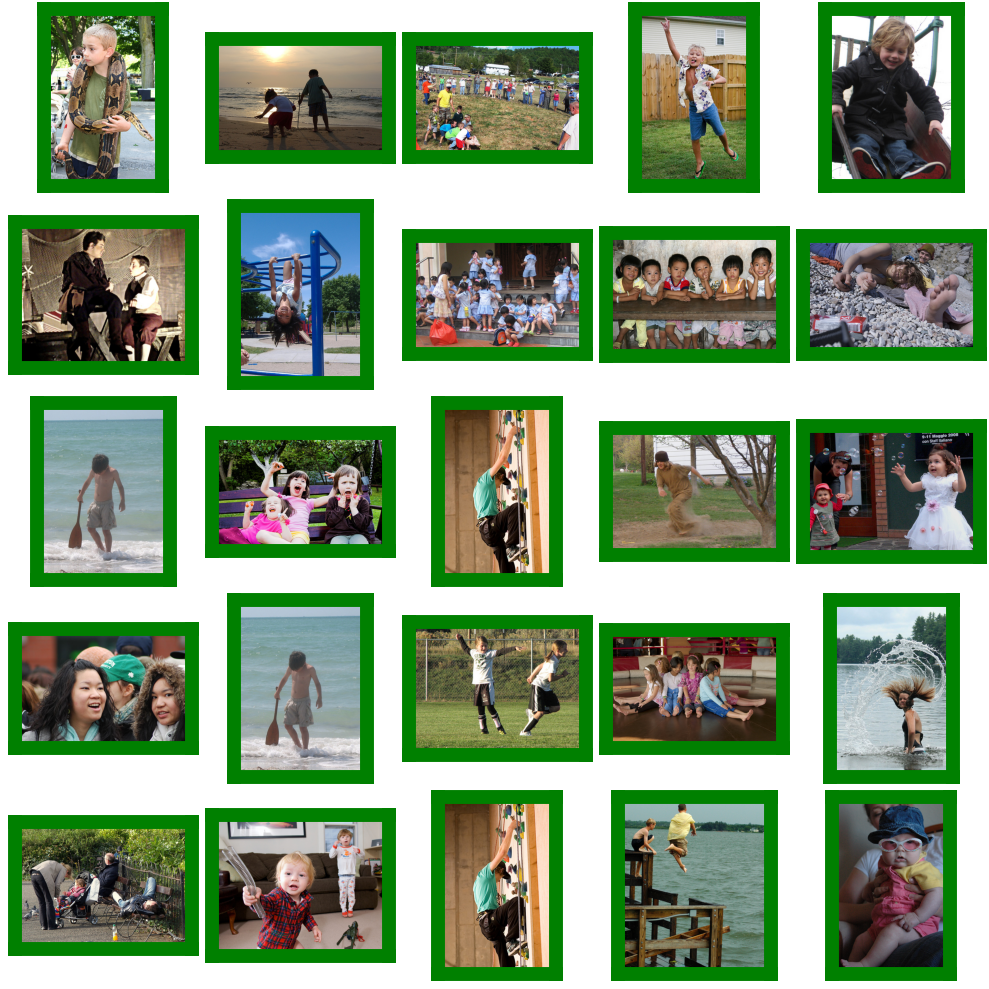

In [165]:
# Посмотрим по фото, что получилось

block_samp = list(df_train[df_train['block'] == 1]
                  ['description_id'].sample(25))

fig = plt.figure(figsize=(10, 10))
for i in range(25):
    fig.add_subplot(5, 5, i+1)
    image = Image.open(Path(PATH, 'train_images', block_samp[i][:-2]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Да, все фото соответствуют 

In [166]:
# Оставим только фото, которые не попадают под ограничения

df_train = df_train.loc[df_train['block'] == False]
df_train.drop(columns=['block'], inplace=True)
df_train.head()

image               description_id  \
21  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
22  3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
23   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
24   488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
25   534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   

                                description_text  results_experts  
21  a man sleep under a blanket on a city street         0.000000  
22  a man sleep under a blanket on a city street         0.333333  
23  a man sleep under a blanket on a city street         0.333333  
24  a man sleep under a blanket on a city street         0.333333  
25  a man sleep under a blanket on a city street         0.000000

In [167]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4176 entries, 21 to 5695
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             4176 non-null   object 
 1   description_id    4176 non-null   object 
 2   description_text  4176 non-null   object 
 3   results_experts   4176 non-null   float64
dtypes: float64(1), object(3)
memory usage: 163.1+ KB


**Удалили все фото описание, которых поподает под ограничения**

## Векторизация изображений

Проведем векторизацию изображений, используя ResNet50

Found 4176 validated image filenames.


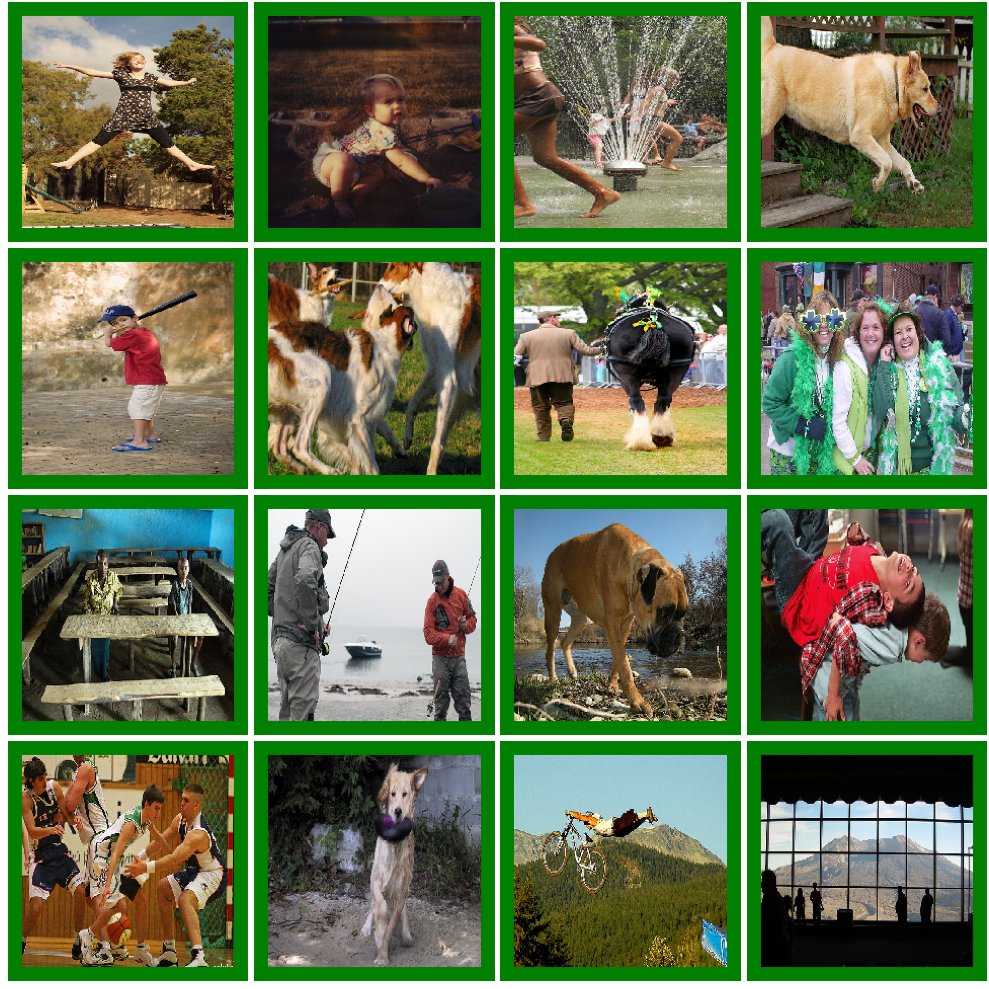

In [168]:
# Загрузим изображения

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=Path(PATH, 'train_images'),
    x_col='image',
    y_col='score',
    target_size=(224, 224),
    batch_size=16,
    class_mode='input',
    seed=12345)

features, target = train_gen_flow.next()

fig = plt.figure(figsize=(10, 10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()


In [169]:
# Создадим свёрточную нейросеть

def create_model():
    backbone = ResNet50(input_shape=(224, 224, 3),
                        include_top=False,
                        weights='imagenet')

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(lr=0.0001), metrics=['mae'])

    return model


In [170]:
# Напишем функцию для создания эмбендингов

def image_vector(model, df_train):
    predictions = model.predict(df_train)
    return predictions


In [171]:
# Получим эмбендинги

image_embedings = image_vector(create_model(), train_gen_flow)


261/261 [==============================] - 573s 2s/step


In [172]:
image_embedings.shape


(4176, 2048)

**Провели векторизацию изображений и получили эмбендинги**

## Векторизация текстов

Проведем векторизацию текста при помощи трансформера bert_small_en_uncased 

In [173]:
# Загрузим трансформер Bert

bert = keras_nlp.models.BertBackbone.from_preset('bert_small_en_uncased')


In [174]:
# Загрузим preprocessor

preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    'bert_small_en_uncased')


In [175]:
# Получим эмбендинги

embeddings = []
text = list(df_train['description_text'])
tokenized = preprocessor(text)
batch_size = 32


for i in notebook.tqdm(range(tokenized['token_ids'].shape[0] // batch_size + 1)):

    tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
    token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
    mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]

    batch = {'token_ids': tokens,
             'segment_ids': token_types,
             'padding_mask': mask}

    batch_embeddings = bert.predict(batch, verbose=0)

    embeddings.append(batch_embeddings['pooled_output'])

embeddings_text = np.concatenate(embeddings)


  0%|          | 0/131 [00:00<?, ?it/s]

In [176]:
embeddings_text.shape


(4176, 512)

## Объединение векторов

In [177]:
# Объеденим вектора

X = np.concatenate((image_embedings, embeddings_text), axis=1)
X.shape


(4176, 2560)

In [178]:

y = np.array(df_train['results_experts'])
y.shape


(4176,)

In [179]:
# Сохраним вектора

with open('X.pickle', 'wb') as f:
    pickle.dump(X, f)

with open('y.pickle', 'wb') as f:
    pickle.dump(y, f)


## Обучение модели предсказания соответствия

Для обучения будем использовать линейные модели, а также нейросеть.  
В качестве метрики будем использовать RMSE, т.к. эта метрика более активно реагигрует на выбросы в отличии от MAE.

In [180]:
# Разделим датасет

gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=SEED)
train_indices, test_indices = next(
    gss.split(X=X, y=y, groups=df_train['image']))


In [181]:
X_train, X_test = X[train_indices], X[test_indices]


In [182]:
y_train, y_test = y[train_indices], y[test_indices]


In [183]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(3380, 2560) (796, 2560) (3380,) (796,)


In [184]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [185]:
%%time

# Линейная регрессия

model_lr = LinearRegression(n_jobs=-1).fit(X_train, y_train)
predictions_lr = model_lr.predict(X_test)
np.sqrt(np.sqrt(mean_squared_error(y_test, predictions_lr)))


CPU times: total: 41.3 s
Wall time: 42.3 s


21.640725522667715

ElasticNet

In [186]:
%%time

# ElasticNet

model_el = ElasticNet(alpha=1, random_state=SEED,
                      l1_ratio=1).fit(X_train, y_train)
predictions_el = model_el.predict(X_test)
np.sqrt(np.sqrt(mean_squared_error(y_test, predictions_el)))


CPU times: total: 219 ms
Wall time: 316 ms


0.5494021040184364

Ridge

In [187]:
%%time

# Ridge

model_r = Ridge().fit(X_train, y_train)
predictions_r = model_r.predict(X_test)
np.sqrt(np.sqrt(mean_squared_error(y_test, predictions_r)))


CPU times: total: 1min 53s
Wall time: 2min 1s


0.6238208190694867

NeuralNetwork

In [195]:
# Создадим четырехслойную нейросеть

model_nn = Sequential()
model_nn.add(Dense(2560, activation='relu', input_shape=(2560,)))
model_nn.add(BatchNormalization())
model_nn.add(Dense(1280, activation='relu'))
model_nn.add(Dropout(0.2))
#model_nn.add(BatchNormalization())
model_nn.add(Dense(640, activation='relu'))
model_nn.add(Flatten())
model_nn.add(Dense(1, activation='relu'))

optimizer = Adam(learning_rate=1e-5)
model_nn.compile(loss='mean_squared_error',
                 optimizer=optimizer,
                 metrics=[RootMeanSquaredError()])


In [196]:
%%time

# Обучим модель

model_nn.fit(X_train,
             y_train,
             epochs=12,
             batch_size=32,
             validation_data=(X_test, y_test),
             verbose=2)


Epoch 1/12
106/106 - 11s - loss: 0.1399 - root_mean_squared_error: 0.3740 - val_loss: 0.1366 - val_root_mean_squared_error: 0.3697 - 11s/epoch - 107ms/step
Epoch 2/12
106/106 - 9s - loss: 0.1378 - root_mean_squared_error: 0.3712 - val_loss: 0.1372 - val_root_mean_squared_error: 0.3704 - 9s/epoch - 89ms/step
Epoch 3/12
106/106 - 9s - loss: 0.1333 - root_mean_squared_error: 0.3652 - val_loss: 0.1371 - val_root_mean_squared_error: 0.3703 - 9s/epoch - 87ms/step
Epoch 4/12
106/106 - 9s - loss: 0.1329 - root_mean_squared_error: 0.3645 - val_loss: 0.1426 - val_root_mean_squared_error: 0.3776 - 9s/epoch - 87ms/step
Epoch 5/12
106/106 - 9s - loss: 0.1275 - root_mean_squared_error: 0.3571 - val_loss: 0.1395 - val_root_mean_squared_error: 0.3735 - 9s/epoch - 86ms/step
Epoch 6/12
106/106 - 10s - loss: 0.1267 - root_mean_squared_error: 0.3559 - val_loss: 0.1375 - val_root_mean_squared_error: 0.3708 - 10s/epoch - 92ms/step
Epoch 7/12
106/106 - 9s - loss: 0.1248 - root_mean_squared_error: 0.3533 - va

Лучшие результаты показала нейросеть, тестировать будем ее.

## Tестирование модели

In [197]:
# Загрузим тестовые изображения

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen_flow = test_datagen.flow_from_dataframe(
    dataframe=test_images,
    directory=Path(PATH, 'test_images'),
    x_col='image',
    y_col=None,
    target_size=(224, 224),
    batch_size=32,
    class_mode='input',
    seed=SEED)


Found 100 validated image filenames.


In [198]:
# Создадим эмбендинг изображений

image_embedings = image_vector(create_model(), test_gen_flow)
image_embedings.shape


4/4 [==============================] - 16s 3s/step


(100, 2048)

In [199]:
def text_vector(text):

    test_embeddings = []
    tokenized = preprocessor(text)
    batch_size = 32

    for i in notebook.tqdm(range(tokenized['token_ids'].shape[0] // batch_size + 1)):
        tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
        token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
        mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]
        batch = {'token_ids': tokens,
                 'segment_ids': token_types,
                 'padding_mask': mask}
        batch_embeddings = bert.predict(batch, verbose=0)
        test_embeddings.append(batch_embeddings['pooled_output'])

    text_embeddings_test = np.concatenate(test_embeddings)
    return text_embeddings_test


In [200]:
def picture(text):

    
    if  len(set(text.split()) & set(BANNED_CONTENT)) > 0:
        print('')
        print('-' * 20, text, '-' * 20)
        print('')
        print('This image is unavailable in your country in compliance with local laws.')
        print('')

    else:
        text_embed = text_vector(text=[text])
        X = np.concatenate((image_embedings, np.resize(
            text_embed, (image_embedings.shape[0], 512))), axis=1)
        X = scaler.transform(X)
        predictions = model_nn.predict(X)

        df = pd.concat((test_images, pd.Series(np.reshape(
            predictions, (predictions.shape[0],)), name='predictions')), axis=1)
        top = list(df.sort_values(by='predictions',
                   ascending=False)['image'].head(10))
        top_score = list(df.sort_values(by='predictions', ascending=False)[
                         'predictions'].head(10))

        print()
        print(text)
        print()

        fig = plt.figure(figsize=(15, 6))
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = 0
        for i in range(10):
            fig.add_subplot(1, 11, i+1, title=round(top_score[i], 2))
            image = Image.open(Path(PATH, 'test_images', top[i]))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()

        if text in list(test_queries['query_text']):
            plt.rcParams['axes.edgecolor'] = 'green'
            plt.rcParams['axes.linewidth'] = 10
            fig.add_subplot(1, 11, 11)
            image = Image.open(Path(
                PATH, 'test_images', test_queries.iloc[test_queries[test_queries['query_text'] == text].index[0]]['image']))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            print()

        plt.show()

        print('-'*100)
    return None


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 19ms/step

A dog jumps to catch a ball in the surf .




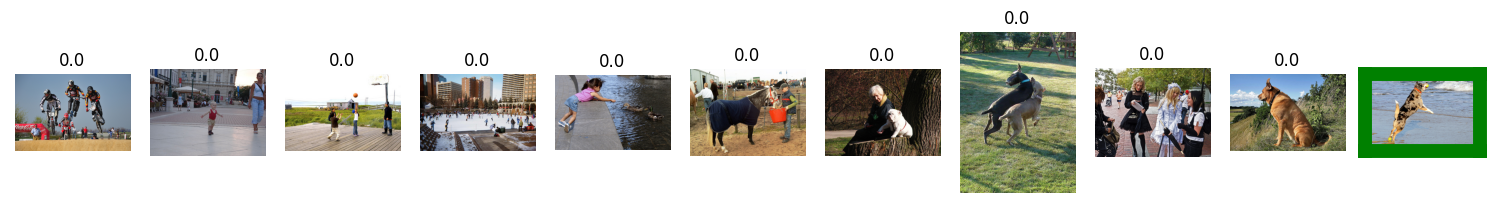

----------------------------------------------------------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 17ms/step

A brown dog is grabbing the collar of a black dog .




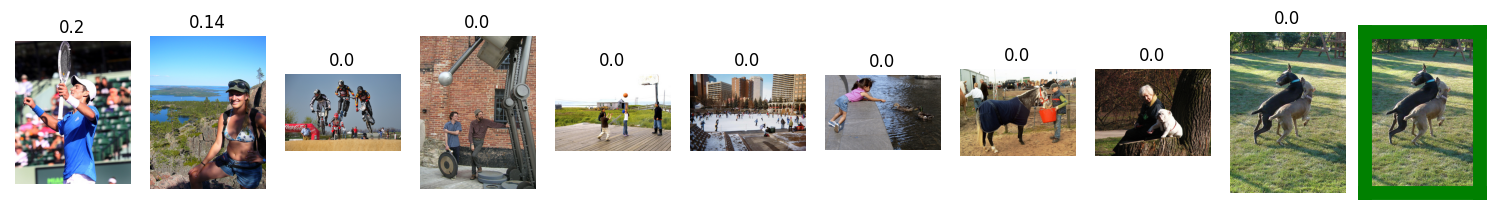

----------------------------------------------------------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 18ms/step

Two men are standing under a large work of art by a brick building .




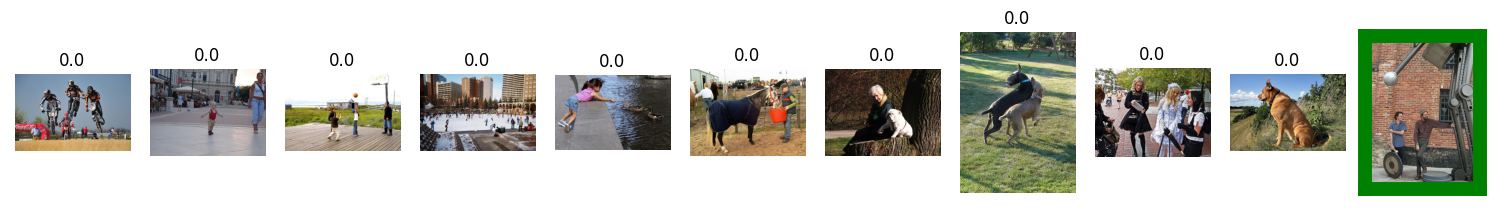

----------------------------------------------------------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 17ms/step

A tan dog runs through the brush .




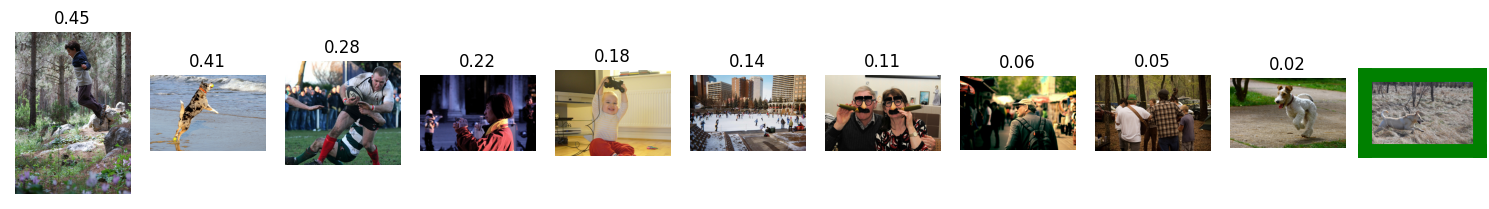

----------------------------------------------------------------------------------------------------

-------------------- A group of children dressed for halloween stand in line with the exception of one girl . --------------------

This image is unavailable in your country in compliance with local laws.



  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 18ms/step

An outdoor ice skating rink full of people .




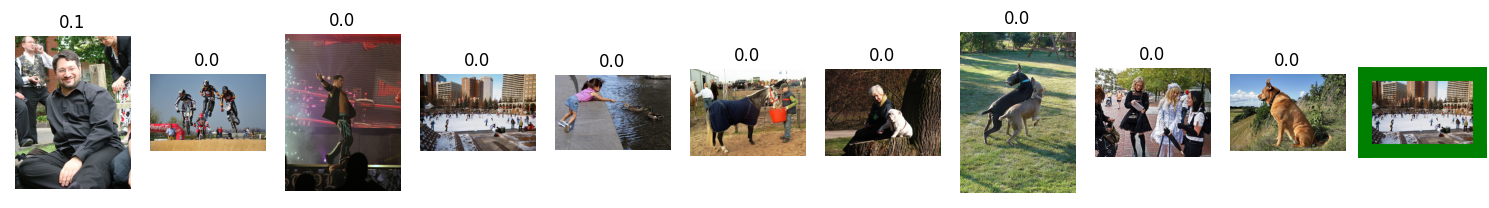

----------------------------------------------------------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 18ms/step

A brown and white dog walks in the snow with a big chunk of snow in his mouth .




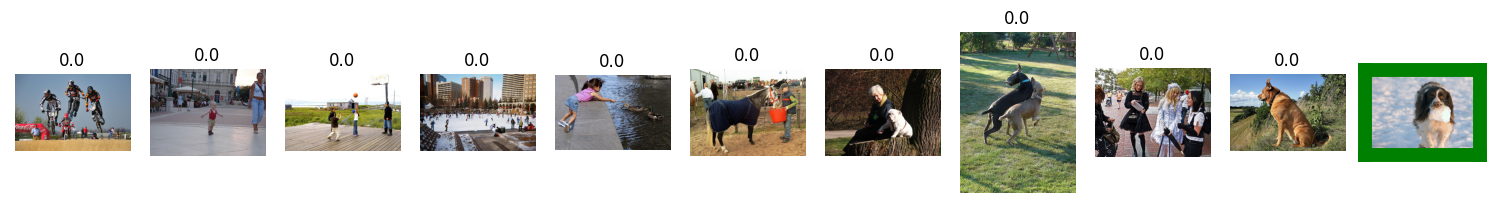

----------------------------------------------------------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 19ms/step

A woman wearing jewelry holds a piece of paper and looks down .




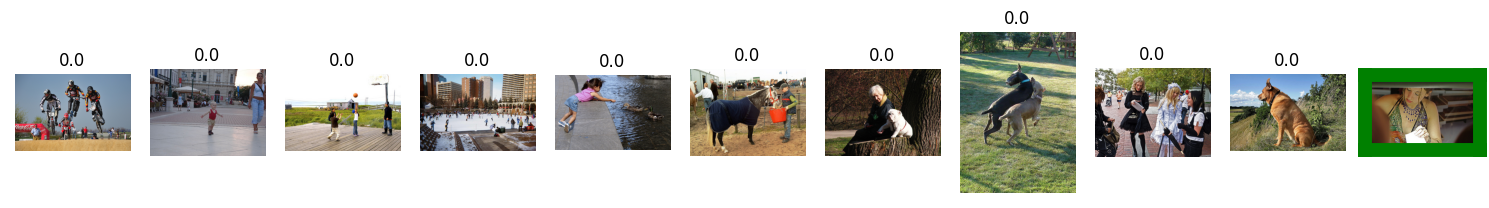

----------------------------------------------------------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 19ms/step

Two Muslim woman wearing their head scarves and frowning faces .




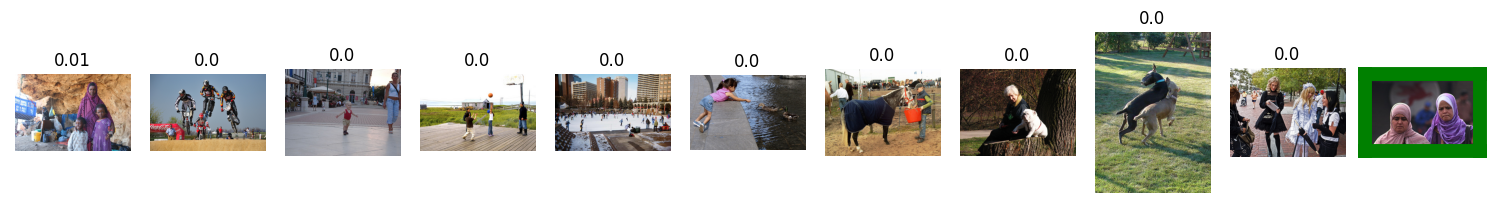

----------------------------------------------------------------------------------------------------

-------------------- Two children are playing at a water park . --------------------

This image is unavailable in your country in compliance with local laws.



In [204]:
test_sampl = list(test_queries['query_text'].sample(10))
for text in test_sampl:
    picture(text)


## Вывод:
В ходе выполнения работы мы удалили запрещенный контент для тренировочных данных, перевели в вектора изображения и тексты при помощи инструментов библиотеки Keras.  
В процессе обучения рассмотрели следующие модели:  
- LinearRegression  
- ElasticNet  
- Ridge  
- четырехслойную нейросеть  
Лучше всех себя показала нейросеть, на которой мы и произвели тестирование.  
К сожалению на тестирование нейросеть показала не очень хорошие, результаты,иногда ей удается найти нужное изображение, а так в основном выводит изображения на которых есть какой-то один из объектов описания.
